In this blog post, we will use the `LogisticRegression` module from `scikit-learn` to confidently determine the species of a penguin in the smallest number of measurements necessary. Our set of data is given in the table below.

In [92]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

species = [s.split()[0] for s in le.classes_]

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)
X_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,41.1,17.5,190.0,3900.0,8.94365,-26.06943,0,1,0,1,0,1,0,1
270,45.4,14.6,211.0,4800.0,8.24515,-25.46782,1,0,0,1,0,1,1,0
271,36.2,17.2,187.0,3150.0,9.04296,-26.19444,0,0,1,1,1,0,1,0
272,50.0,15.9,224.0,5350.0,8.20042,-26.39677,1,0,0,1,0,1,0,1


We need to find the combination of features with which we can determine the species of a penguin the fastest. We can accomplish this by running an exhaustive search of all the features contained in this data set. At each iteration, we use the `LogisticRegression` module to test the score on the current set of features.

In [74]:
#| echo: false
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [77]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression

# these are not actually all the columns: you'll 
# need to add any of the other ones you want to search for
all_qual_cols = ["Clutch Completion", "Sex", 'Island']
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']
best_score = 0
best_col = 0
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = list(pair) + qual_cols
    LR = LogisticRegression()
    LR.fit(X_train[cols], y_train)
    if best_score < LR.score(X_train[cols], y_train):
        best_col = cols
        best_score = LR.score(X_train[cols], y_train)
print(best_col)

['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']


We can visualize the training data by using `Seaborn` and apply it on the most efficient combination of features that we have just found.

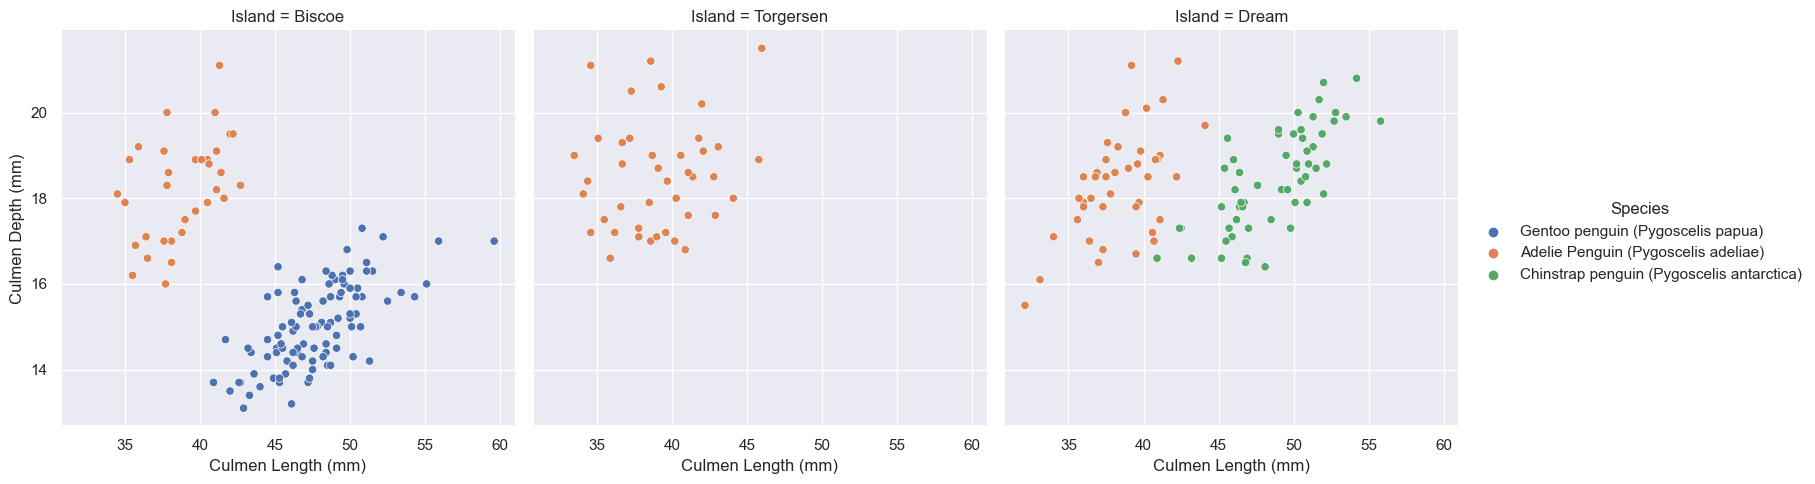

In [97]:
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Create a visualization
sns.relplot(
    data=train,
    x="Culmen Length (mm)", y="Culmen Depth (mm)", col="Island", hue ='Species')

We can see that the training data is linearly separable. This means that the score on our logistic regression should be 100%.

In [95]:
LR = LogisticRegression()
LR.fit(X_train[best_col], y_train)
LR.score(X_train[best_col], y_train)

1.0

And it is 100%! Next we will visualize the linear separation of our data.

In [76]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

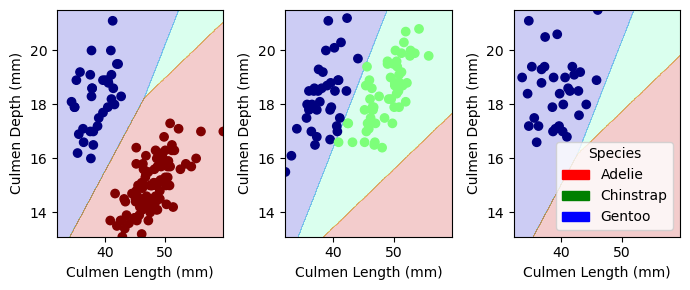

In [80]:
plot_regions(LR, X_train[best_col], y_train)

These 3 graphs correspond to the 3 islands: Biscoe, Dream and Torgensen.

Now that we have established that "Culmen Length", "Culmen Depth" and "Island" make the best feature combination, we will test this out on new data.

In [98]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

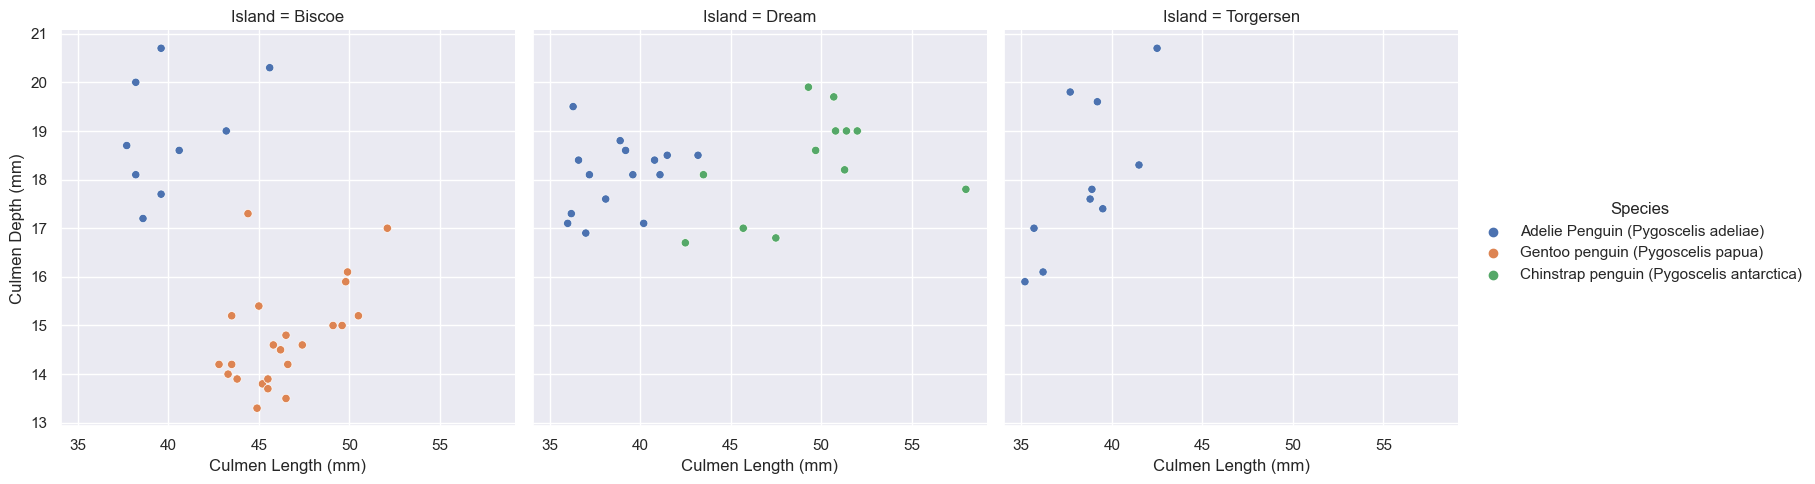

In [96]:
sns.relplot(
    data=test,
    x="Culmen Length (mm)", y="Culmen Depth (mm)", col="Island", hue ='Species')

The data set, as organized by our feature combination, is again linearly separable. Does this guarantee a score of 100%?

In [99]:
X_test, y_test = prepare_data(test)
LR.score(X_test[best_col], y_test)

1.0

So it does!